In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter

from vision.tools.camera import find_gl_by_percentile, plot_img, plot_two_img
from vision.depth.slicer.slicer import get_grad, get_search_limits, find_best_routh, slice_frame
from vision.depth.slicer.slicer import find_tree_height_limits, find_local_minimum, remove_windows, reduce_neighbours
from vision.depth.slicer.slicer import print_lines


Bad key "text.kerning_factor" on line 4 in
/home/yotam/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def plot_img_and_line(img, x1, y1, x2=None, y2=None):
    f, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img)
    ax.plot(x1, y1, 'b')
    if x2 is not None and y2 is not None:
        ax.plot(x2, y2, 'r')

In [26]:
f_id = 213
fp = f"/home/yotam/FruitSpec/Sandbox/slicer_test/caracara_R2_3011/sliced3/depth/depth_frame_{f_id}.jpg"
depth = cv2.imread(fp)
depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
fp = f"/home/yotam/FruitSpec/Sandbox/slicer_test/caracara_R2_3011/sliced3/frames/frame_{f_id}.jpg"
frame = cv2.imread(fp)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

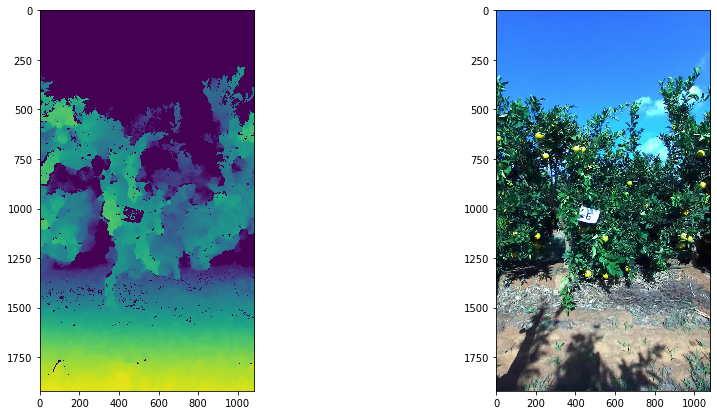

In [27]:
plot_two_img(depth, frame)

In [6]:
gaps = slice_frame(depth)
print(gaps)

[]


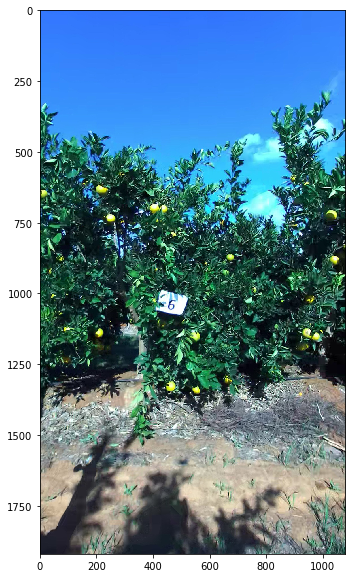

In [28]:
output = frame.copy()
s, e = find_tree_height_limits(depth)
for i in gaps:
    cv2.line(output, (i+1, s), (i+1, e), (255, 0, 255), 2)
plot_img(output)

In [7]:
s, e = find_tree_height_limits(depth)
print(s)
print(e)
cropped_depth = depth[s:e, :].copy()
vec = find_local_minimum(cropped_depth)
print(vec)


305
1309
[436, 456, 520]


In [8]:
vec1 = vec.copy()
vec2 = remove_windows(depth, vec1, s, e, signal_thrs=10, window_thrs=0.8)
print(vec2)

[]


In [ ]:
window_thrs=0.8
signal_thrs=10
final = []
index_ = vec1[0]
mid = (s + e) // 2

# seperate the signal to two halfs
uppper_signal_vec = depth[start:mid, index_].copy()
lower_signal_vec = depth[mid: end, index_].copy()

# how many below threshold - no signal
upper = np.sum(uppper_signal_vec < signal_thrs) / (mid - start)
lower = np.sum(lower_signal_vec < signal_thrs) / (end - mid)

if upper > window_thrs and lower > window_thrs:
    # valid
    final.append(index_)
elif upper > window_thrs and lower < window_thrs:
    # upper window
    continue
elif upper < window_thrs and lower > window_thrs:
    # lower window
    continue
else:  # gap - valid
    final.append(index_)


In [18]:
if len(vec2) > 1:
    vec3 = reduce_neighbours(depth, vec2, s, e)
print(vec3)

[]


In [23]:
last = vec2[0]
neighbours = [last]
reduced = []
for i in vec[1:]:
    if np.abs(i - neighbours[-1]) < 150:
        neighbours.append(i)
        print(neighbours)
    else:
        score = np.array([])
        for n in neighbours:
            score = np.append(score, np.sum(depth[s:e, n]))
        j = np.argmin(score)
        reduced.append(neighbours[j])

        neighbours = [i]
        if i == vec[-1]:  # last
            reduced.append(i)
if len(neighbours) > 1:
    score = np.array([])
    for n in neighbours:
        score = np.append(score, np.sum(depth[s:e, n]))
    j = np.argmin(score)
    reduced.append(neighbours[j])
            
print(reduced)

[260, 294]
[294]


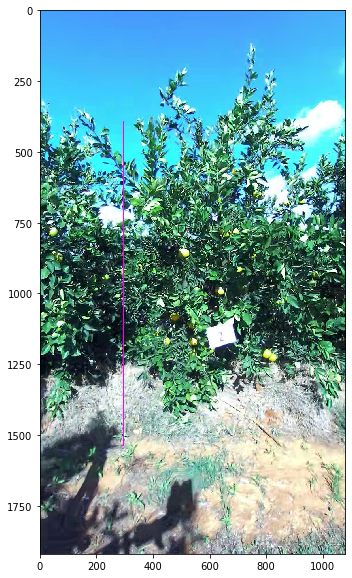

In [24]:
output = print_lines(frame, depth, reduced)
plot_img(output)